In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from tensorflow.keras import layers, models
from keras.applications import InceptionV3

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D

from sklearn.metrics import confusion_matrix


import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.WARNING)


In [2]:
base_path = "dataset"
dogs_directory = "dog"
cats_directory = "cat"

In [6]:
def load_and_preprocess_data(dataset_path):
    images = []
    labels = []

    for label, category in enumerate([dogs_directory , cats_directory]):
        category_path = os.path.join(base_path, category)
        for filename in os.listdir(category_path):
            if filename.endswith(".jpg"):
                image_path = os.path.join(category_path, filename)
                image = cv2.imread(image_path)

                if image is not None and not image.size:
                    print(f"Invalid image size: {image_path}")
                    continue

                image = cv2.resize(image, (128, 128))  
                images.append(image)
                labels.append(label)

    images = np.array(images)
    labels = to_categorical(labels, num_classes=2) 

    return images, labels

images, labels = load_and_preprocess_data(base_path)

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
def plot_graphs(train_loss , validation_loss , train_accuracy , validation_accuracy ):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    ax1 = axes[0]
    ax1.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    ax1.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')

    ax1.set_title(f'Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2 = axes[1]
    ax2.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
    ax2.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')

    ax2.set_title(f'Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()


    plt.tight_layout()
    plt.show()

In [31]:
y_train_indices = torch.argmax(torch.from_numpy(y_train), dim=1)
y_test_indices = torch.argmax(torch.from_numpy(y_test), dim=1)

X_train, y_train = torch.from_numpy(X_train).permute(0, 3, 1, 2).float(), y_train_indices.long()
X_test, y_test = torch.from_numpy(X_test).permute(0, 3, 1, 2).float(), y_test_indices.long()

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [32]:
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 2)  

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(-1, 128 * 16 * 16)
        
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x


In [39]:
def execute_model(  pytorch_model , epoch=5 ):
    
    optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler
    criterion = nn.CrossEntropyLoss()

    num_epochs = epoch

    train_loss = []
    train_accuracy = []
    validation_loss = []
    validation_accuracy = []

    for epoch in range(num_epochs):
        pytorch_model.train()
        epoch_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = pytorch_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
    
            nn.utils.clip_grad_norm_(pytorch_model.parameters(), 1.0)
            
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        average_epoch_loss = epoch_loss / len(train_loader)
        accuracy = correct_predictions / len(train_loader.dataset)

        pytorch_model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        
        test = []
        predicted = []

        with torch.no_grad():
            for val_inputs, val_labels in test_loader:
                val_outputs = pytorch_model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

                _, val_predicted = torch.max(val_outputs, 1)
                
                test.append(val_labels)
                predicted.append(val_predicted)
    
                val_correct_predictions += (val_predicted == val_labels).sum().item()

        average_val_loss = val_loss / len(test_loader)
        val_accuracy = val_correct_predictions / len(test_loader.dataset)

        train_loss.append(float("{:.4f}".format(average_epoch_loss)))
        train_accuracy.append(float("{:.2f}".format(accuracy * 100)))
        validation_loss.append(float("{:.4f}".format(average_val_loss)))
        validation_accuracy.append(float("{:.2f}".format(val_accuracy * 100)))

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {average_epoch_loss:.4f}, Train Accuracy: {accuracy * 100:.2f}%, "
              f"Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    return train_loss, train_accuracy, validation_loss, validation_accuracy, pytorch_model , test , predicted

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loss, train_accuracy, validation_loss, validation_accuracy, pytorch_model , test , predicted= execute_model( ImprovedCNN().to(device))



Epoch 1/5, Train Loss: 0.5443, Train Accuracy: 72.52%, Val Loss: 0.4391, Val Accuracy: 79.62%
Epoch 2/5, Train Loss: 0.4111, Train Accuracy: 81.28%, Val Loss: 0.4475, Val Accuracy: 79.03%
Epoch 3/5, Train Loss: 0.3480, Train Accuracy: 84.86%, Val Loss: 0.4423, Val Accuracy: 79.43%
Epoch 4/5, Train Loss: 0.3012, Train Accuracy: 87.06%, Val Loss: 0.3657, Val Accuracy: 84.13%
Epoch 5/5, Train Loss: 0.2483, Train Accuracy: 89.71%, Val Loss: 0.3838, Val Accuracy: 84.69%


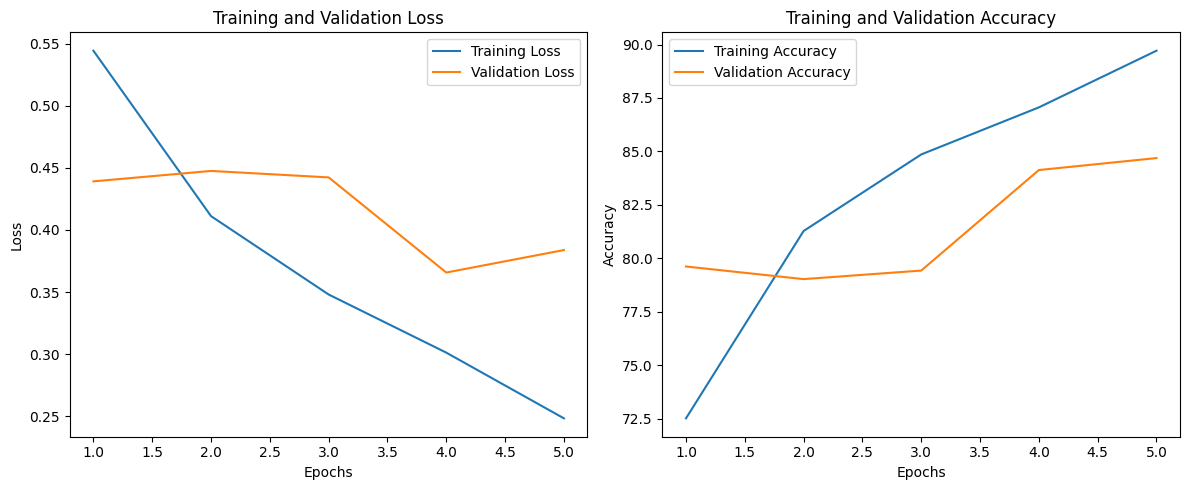

In [41]:
plot_graphs(train_loss , validation_loss , train_accuracy , validation_accuracy )

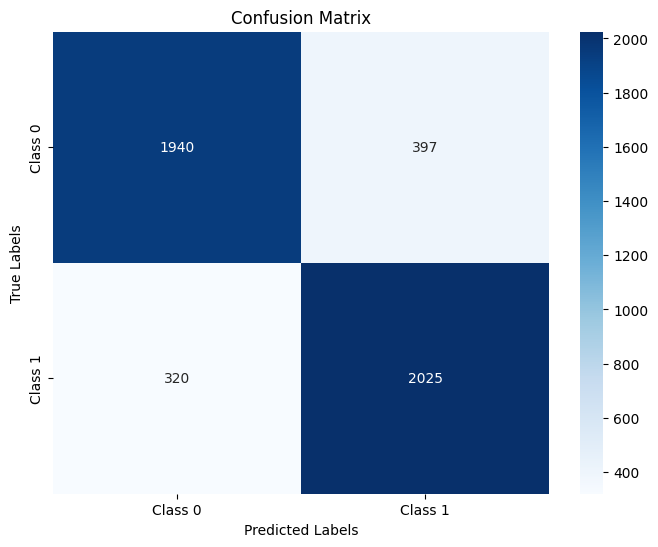

In [49]:
cm = confusion_matrix(np.concatenate([t.numpy() for t in test]),  np.concatenate([t.numpy() for t in predicted]))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()